# Trabalho Prático: Competição Kaggle

## Imports:

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, plot_confusion_matrix,ConfusionMatrixDisplay, classification_report

from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Read DataSet

In [122]:
df = pd.read_csv("sbstpdaa2223/training_data.csv")

## Data Visualization

In [123]:
print("** INFO **")
print(df.info())
#print("** DESCRIBE **")
#print(df.describe())
print("** HEAD **")
print(df.head())
#print("** CORR MATRIX **")
#sns.heatmap(df.corr())
#plt.show()
print("** NULL VALUES?? **") # check if there are any missing values in this dataframe
print(df.isnull().sum())

** INFO **
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           5000 non-null   object 
 1   magnitude_of_delay  5000 non-null   object 
 2   delay_in_seconds    5000 non-null   int64  
 3   affected_roads      4915 non-null   object 
 4   record_date         5000 non-null   object 
 5   luminosity          5000 non-null   object 
 6   avg_temperature     5000 non-null   float64
 7   avg_atm_pressure    5000 non-null   float64
 8   avg_humidity        5000 non-null   float64
 9   avg_wind_speed      5000 non-null   float64
 10  avg_precipitation   5000 non-null   float64
 11  avg_rain            5000 non-null   object 
 12  incidents           5000 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 507.9+ KB
None
** HEAD **
   city_name magnitude_of_delay  delay_in_seconds  \
0  Guimaraes  

### Análise da Data Visualization:

* Primeira coisa que podemos observar é que neste data set existem dados categoricos, contudo, as funções disponibilizadas pelo sklearn só trabalham com dados numéricos, portanto, é necessário, fazer encoding destes valores.

* Podemos também observar a existência de missing values na coluna **affected_roads**. Para tratar estes podemos tentar diferentes abordagens. Podemos tentar fazer drop dessas linhas (dado que são relativamente poucas linhas 85 em 5000, contudo, devemos verificar se não muita perda de dados), ou replace by the mean (contudo, esta linha é do tipo categórico, temos que ver isso primeiro maybe).

* Relembrar que a target label é a coluna **incidents**

* Podemos constatar que a coluna **avg_precipitation** tem uma std igual 0, portanto, todos os valores são iguais. Assim, podemos observar que esta coluna não introduz muito para este modelo


## Preprocessing

In [124]:
def getReplaceMap(df, nameColumn):
    labels = df[nameColumn].astype('category').cat.categories.tolist()
    replace_map = {nameColumn:{k: v for v,k in zip(labels,list(range(1,len(labels)+1)))}}
    #print(replace_map)
    return replace_map

In [125]:
def replaceRecordDate(df):
    df['record_date'] = pd.to_datetime(df['record_date'], format = "%Y-%m-%d %H:%M", errors='coerce')

    assert df['record_date'].isnull().sum() == 0, 'missing record date'
    
    df['record_date_year'] = df['record_date'].dt.year  #Não tem muito valor => todos estes acidentes foram no mesmo ano
    
    df['record_date_month'] = df['record_date'].dt.month
    df['record_date_day'] = df['record_date'].dt.day
    df['record_date_hour'] = df['record_date'].dt.hour
    
    df.drop('record_date', axis = 1, inplace= True)

## Encoding Categorical Data

* Utilizando label encoding

In [126]:
replace_map_city_name = getReplaceMap(df,'city_name')
print(replace_map_city_name)
df.replace(replace_map_city_name, inplace = True)

replace_magnitude_delay = getReplaceMap(df,'magnitude_of_delay')
print(replace_magnitude_delay)
df.replace(replace_magnitude_delay, inplace=True)

#replace_affected_roads = getReplaceMap(df, 'affected_roads')
#df.replace(replace_affected_roads, inplace = True)

replace_luminosity = getReplaceMap(df, 'luminosity')
df.replace(replace_luminosity, inplace=True)
replace_avg_rain = getReplaceMap(df, 'avg_rain')
df.replace(replace_avg_rain, inplace=True)

replace_incidents = getReplaceMap(df, 'incidents')
df.replace(replace_incidents, inplace=True)

#replaceRecordDate(df)

{'city_name': {1: 'Guimaraes'}}
{'magnitude_of_delay': {1: 'MAJOR', 2: 'MODERATE', 3: 'UNDEFINED'}}


## Data Visualization After Encoding Categorical Data

** HEAD **
   city_name magnitude_of_delay  delay_in_seconds  \
0  Guimaraes          UNDEFINED                 0   
1  Guimaraes          UNDEFINED               385   
2  Guimaraes          UNDEFINED                69   
3  Guimaraes              MAJOR              2297   
4  Guimaraes          UNDEFINED                 0   

                                      affected_roads       record_date  \
0                                                  ,  2021-03-15 23:00   
1                                              N101,  2021-12-25 18:00   
2                                                  ,  2021-03-12 15:00   
3  N101,R206,N105,N101,N101,N101,N101,N101,N101,N...  2021-09-29 09:00   
4                          N101,N101,N101,N101,N101,  2021-06-13 11:00   

  luminosity  avg_temperature  avg_atm_pressure  avg_humidity  avg_wind_speed  \
0       DARK             12.0            1013.0          70.0             1.0   
1       DARK             12.0            1007.0          91.0  

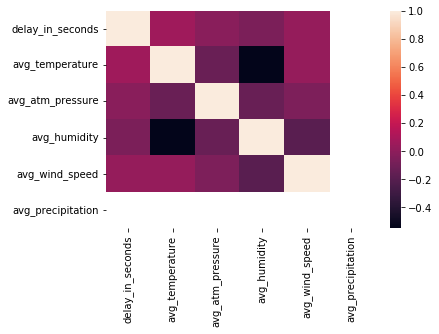

In [127]:
print("** HEAD **")
print(df.head())

print("** DESCRIBE **")
print(df.describe())

print("** CORR MATRIX **")
sns.heatmap(df.corr())
plt.show()

In [128]:
def preprocessing(df, istest):
    df.drop(['affected_roads'],axis=1, inplace = True)

    # O atributo cidade não acrescenta nada, uma vez que tem todos os mesmo valor, e portanto não vai afetar o modelo
    df.drop('city_name', axis = 1, inplace = True)

    # O atributo avg_precipitation também é unico por isso não acrescenta muito 
    #print(df_no_city['avg_precipitation'].nunique())
    df.drop('avg_precipitation', axis = 1, inplace = True)

    labels = df['avg_rain'].astype('category').cat.categories.tolist()
    replace_map_rain = {'avg_rain':{k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
    #print(replace_map_rain)
    df.replace(replace_map_rain, inplace = True)

    if(istest == True):
        labels = df['incidents'].astype('category').cat.categories.tolist()
        replace_map_incidents = {'incidents':{k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
        #print(replace_map_incidents)
        df.replace(replace_map_incidents, inplace = True)


    labels = df['magnitude_of_delay'].astype('category').cat.categories.tolist()
    replace_map_delay = {'magnitude_of_delay':{k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
    #print(replace_map_delay)
    df.replace(replace_map_delay, inplace = True)

    labels = df['luminosity'].astype('category').cat.categories.tolist()
    replace_map_luminosity = {'luminosity':{k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
    #print(replace_map_luminosity)
    df.replace(replace_map_luminosity, inplace = True)


    df['record_date'] = pd.to_datetime(df['record_date'], format = "%Y-%m-%d %H:%M", errors='coerce')

    assert df['record_date'].isnull().sum() == 0, 'missing record date'
    
    #Não tem muito valor => todos estes acidentes foram no mesmo ano
    #df['record_date_year'] = df['record_date'].dt.year
    
    df['record_date_month'] = df['record_date'].dt.month
    df['record_date_day'] = df['record_date'].dt.day
    df['record_date_hour'] = df['record_date'].dt.hour
    
    df.drop('record_date', axis = 1, inplace= True)

## Get Model

In [129]:
def getModel(modelType):
    if (modelType == "DecisionTree"):
        model = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = 10)
    elif(modelType == "RandomForest"):
        model = RandomForestClassifier(criterion = 'entropy', n_estimators = 125)
    else:
        model = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best')
    return model


def gridSearch(model, params):

    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid = GridSearchCV(model,params,scoring='neg_mean_squared_error',n_jobs=-1, cv=cv)
    
    return grid

In [130]:
def Split_Training_Test_Set(df):
    X = df.drop(['incidents'], axis = 1)
    y = df['incidents']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    return X_train, X_test, y_train, y_test

## Train Models

In [131]:
def test_model(df):
    X_train, X_test, y_train, y_test = Split_Training_Test_Set(df)

    #Decision Tree Model
    model = getModel("RandomForest")

    model = model.fit(X_train, y_train)
    y_pred_tree = model.predict(X_test)
    # Classification_report
    print(classification_report(y_test,y_pred_tree))

    scores = cross_val_score(model, X, y, cv=10)
    print(scores.mean())

    #Decision Tree:
    # log_loss deu asneira
    #params = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [5,10,15]}    
    #grid = gridSearch(model, params)
    #grid = grid.fit(X, y)
    #print(grid.best_params_)

    #Random Forest Classifier:
    # log_loss deu asneira
    #params = {'criterion': ['entropy'], 'max_depth': [13,15,18], 'n_estimators': [120, 125, 130]}    
    #grid = gridSearch(model, params)
    #grid = grid.fit(X,y)
    #print(grid.best_params_)

## Build File with Predictions

In [132]:
def predict_doc(df):
    ## TESTE
    X = df.drop(['incidents'], axis = 1)
    y = df['incidents']
    modelTree = getModel("RandomForest")
    modelTree = modelTree.fit(X, y)


    df_test = pd.read_csv("sbstpdaa2223/test_data.csv")
    preprocessing(df_test, False)

    y_pred_tree = modelTree.predict(df_test)
    # Classification_report
    #print(classification_report(y_test,y_pred_tree))


    pred = pd.DataFrame()
    print(dictReplaceIncidents)

    # RowId,Incidents
    pred['RowId'] = range(1, len(y_pred_tree)+1)
    pred['Incidents'] = y_pred_tree
    pred.replace(dictReplaceIncidents, inplace=True)
    pred.to_csv('Group16_Try2.csv', index = False)  

** INFO **
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           5000 non-null   object 
 1   magnitude_of_delay  5000 non-null   object 
 2   delay_in_seconds    5000 non-null   int64  
 3   affected_roads      4915 non-null   object 
 4   record_date         5000 non-null   object 
 5   luminosity          5000 non-null   object 
 6   avg_temperature     5000 non-null   float64
 7   avg_atm_pressure    5000 non-null   float64
 8   avg_humidity        5000 non-null   float64
 9   avg_wind_speed      5000 non-null   float64
 10  avg_precipitation   5000 non-null   float64
 11  avg_rain            5000 non-null   object 
 12  incidents           5000 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 507.9+ KB
None
** DESCRIBE **
       delay_in_seconds  avg_temperature  avg_atm_pressure  avg

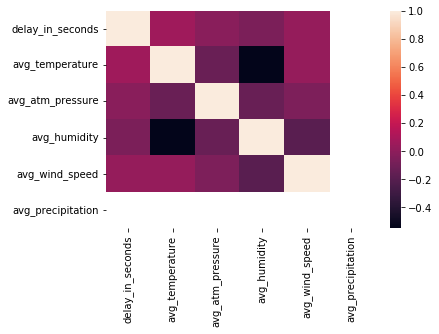

** NULL VALUES?? **
city_name              0
magnitude_of_delay     0
delay_in_seconds       0
affected_roads        85
record_date            0
luminosity             0
avg_temperature        0
avg_atm_pressure       0
avg_humidity           0
avg_wind_speed         0
avg_precipitation      0
avg_rain               0
incidents              0
dtype: int64
** INFO **
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   magnitude_of_delay  5000 non-null   int64  
 1   delay_in_seconds    5000 non-null   int64  
 2   luminosity          5000 non-null   int64  
 3   avg_temperature     5000 non-null   float64
 4   avg_atm_pressure    5000 non-null   float64
 5   avg_humidity        5000 non-null   float64
 6   avg_wind_speed      5000 non-null   float64
 7   avg_rain            5000 non-null   int64  
 8   incidents           5000 non-

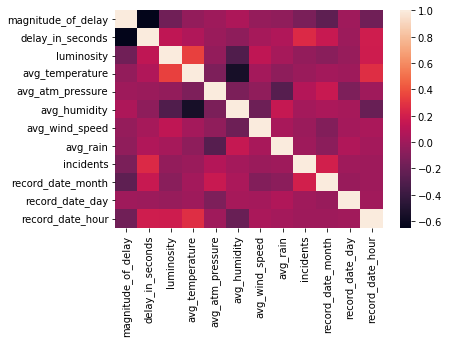

** NULL VALUES?? **
magnitude_of_delay    0
delay_in_seconds      0
luminosity            0
avg_temperature       0
avg_atm_pressure      0
avg_humidity          0
avg_wind_speed        0
avg_rain              0
incidents             0
record_date_month     0
record_date_day       0
record_date_hour      0
dtype: int64
              precision    recall  f1-score   support

           1       0.87      0.90      0.88       305
           2       0.86      0.90      0.88       211
           3       0.88      0.76      0.82       185
           4       0.97      0.98      0.97       622
           5       0.90      0.91      0.91       177

    accuracy                           0.92      1500
   macro avg       0.90      0.89      0.89      1500
weighted avg       0.92      0.92      0.91      1500

0.9222000000000001


In [133]:
if __name__ == "__main__":
    dataVisualization(df)
    dictReplaceIncidents = getMapIncidents(df)
    preprocessing(df, True)
    dataVisualization(df)
    
    #dataVisualization(df)

    test_model(df)
    
    #predict_doc(df)